# Word Embeddings and Text Embeddings: a Comparison

In this article we look at how the mechanism of embedding a word (or more exactly a token) works, and how this embedding develops from context-independent to in-context when going through transformers. We do not look into the technical details but observe the behaviour of these embeddings, from a heuristic point of view.

We then look at the embeddings of entire texts. We focus on the embeddings from OpenAI, and observe their behaviour on very simple (toy) examples, to learn how they behave and understand what are the strengths and weaknesses of using such techniques.

This analysis is especially relevant in the context of semantic-based enterprise search applications, where text embeddings can be used at large scale, to index texts. While text embeddings seems to be the main approach at the moment, we also see other approaches based on embeddings of single words. One such example is ColBERTv2 (<a href="https://github.com/stanford-futuredata/ColBERT">link</a>).

## Context-Independent vs. In-Context for single words

In this section, we look at how a single word is encoded into a vector initially independent of any contexts. Then we look at how this vector develops when going through transformers to become context-dependent.

We will do this experiment using the Large Language Model (LLM) BERT, and we will observe with a couple of examples how a single word develops through the various layers of transformers that are in BERT. In total, there are 25 layers. The size of the vectors that embed a word (1024) is too large to be visualized. This is why we use a technique called Truncated SVD to reduce the size to 2 dimensions, keeping the main differences between the vectors visible.

The experiment consists of looking at one word which has different meanings depending on the context. These words are called homonyms. We will build several sentences using the word "park", in which this word has different meanings. Then we will let these sentences go through transformers and follow the evolution of the embedding for the word "park" in each layer of the transformers. We will observe that depending on the meaning of the word, the embeddings representing this word will diverge into various clusters.

Technically, these are not words but tokens. Tokens are pieces of words, depending on how frequent such a word is expected to appear in texts.

First we need to install all the libraries that will be needed for this work.

In [5]:
#!pip install transformers
#!pip install torch

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
#import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

Let's load the BERT model from Hugging Face. We use BERT large, because we want to have many layers to see the development of the embeddings along the layers. By default, only the last layer is available in these models, because it is the only layer that is needed when using BERT in real cases. In our case though, we want to see the intermediate layers, which is why we adjust the configuration of the model.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
model = AutoModel.from_pretrained("bert-large-uncased")
model.config.output_hidden_states = True

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


You might get a warning message. This is if you use BERT in a different context. You can ignore this message.

Let's look at how this model works by getting the encoded input and the output.

In [6]:
text = "During lunch today she will park the car."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [7]:
# Encoded input
print("Encoded input: ", encoded_input)
print(50*'-')
print("Input tensor: ",encoded_input['input_ids'].shape)
print(50*'-')
print(tokenizer.decode(torch.squeeze(encoded_input['input_ids'])))

Encoded input:  {'input_ids': tensor([[ 101, 2076, 6265, 2651, 2016, 2097, 2380, 1996, 2482, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
--------------------------------------------------
Input tensor:  torch.Size([1, 11])
--------------------------------------------------
[CLS] during lunch today she will park the car. [SEP]


The text that we input is encoded into tokens (i.e. 101, 2076, ...) that represent each word, or piece of words. For example, the token 2380 represents the word "park". To see what is happening we can decode this encoded text and see what comes out: additional "words" are added at the start and the end. All capital letter are converted to lower case.

Note that there are 11 tokens. This will be relevant when looking at the output.

In [8]:
print("Output type: ", type(output))
print(50*'-')
print("Output keys: ", output.keys())
print(50*'-')
print("Number of layers: ", len(output['hidden_states']))
print(50*'-')
print("Output layer: ", output['last_hidden_state'])
print(50*'-')
print("Shape of output layer: ", output['last_hidden_state'].shape)

Output type:  <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
--------------------------------------------------
Output keys:  odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])
--------------------------------------------------
Number of layers:  25
--------------------------------------------------
Output layer:  tensor([[[-0.4712, -0.0790, -1.2281,  ..., -0.5111,  0.1752,  0.2754],
         [-0.8398,  0.1331, -0.5745,  ...,  0.0058, -0.4018,  0.3348],
         [-1.4074, -0.1163, -0.5886,  ...,  0.1395,  0.2122,  0.1720],
         ...,
         [-0.5041,  0.0119, -0.5575,  ..., -0.2656,  0.7398,  0.1464],
         [-0.5106,  0.9248, -0.6897,  ..., -1.0248, -1.3866,  0.2352],
         [-0.4892, -0.1844, -0.8645,  ..., -0.4099,  0.3301, -0.0318]]],
       grad_fn=<NativeLayerNormBackward0>)
--------------------------------------------------
Shape of output layer:  torch.Size([1, 11, 1024])


The output consists of an object that contains several attributes that can be called the same way we use a Python dictionary.

The hidden states are the states of the text going through the transformers. These are tuples, each element of the tuple being a state. Each state has the same shape as the last hidden state.

The "last hidden state", which is the last layer that has gone through the transformers, has a shape 11x1024, where 11 is the number of tokens in input. This means that each of the 11 tokens is represented by a vector of size 1024 in the last layer of the transformer.

Now that we have understood how this model is implemented in the Transformers library, let's start our experiment and collect a set of sentences, where the word "park" is used with various meanings.

Let's do some processing in order to make all these sentences go through the BERT model. We need to identify which token corresponds to the word "park", since we will need to isolate its embedding for further analysis.

In [9]:
texts = ["During lunch today she will park the car."
         ,"They will meet in the park."
         ,"Typically, on Sundays the closest park is crowded."
         ,"It is very difficult to park in town."]

In [10]:
encoded_input = []
for t in texts:
    encoded_input.append(tokenizer(t, return_tensors='pt'))
print(encoded_input)

[{'input_ids': tensor([[ 101, 2076, 6265, 2651, 2016, 2097, 2380, 1996, 2482, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[ 101, 2027, 2097, 3113, 1999, 1996, 2380, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[  101,  4050,  1010,  2006, 14803,  1996,  7541,  2380,  2003, 10789,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[ 101, 2009, 2003, 2200, 3697, 2000, 2380, 1999, 2237, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}]


In [11]:
tokenizer.decode([2380])

'park'

Since we will need to identify the embedding corresponding to "park", let's find its position in each sentence.

In [12]:
index_word=[]
for e in encoded_input:
    x = e['input_ids'].squeeze()
    index_word.append((x==2380).nonzero().item())
print("Position of 'park': ", index_word)

Position of 'park':  [6, 6, 7, 6]


Let's focus on the output now. We will get the output of each text (from texts) in a list (output). For each text, we will put the sequence of all hidden states into a list (layers).

In [13]:
output = []
for e in encoded_input:
    output.append(model(**e))

In [14]:
# Get model output in a list output
output = []
for e in encoded_input:
    output.append(model(**e))

# Get hidden states for each text in a list layers
layers = []
# Loop on texts
for (i,ot) in enumerate(output):
    la = []
    # Add all hidden layers
    for hs in ot['hidden_states']:
        la.append(hs[:,index_word[i],:])
    layers.append(la)
nr_texts, nr_layers = (len(layers), len(layers[0]))
print("Number of texts: ", nr_texts)
print("Number of layers per text: ", nr_layers)

Number of texts:  4
Number of layers per text:  25


Next we need to do some additional processing and pack the data in a convenient way for further analysis.

In [15]:
# Get all vectors packed together and build a label (for displaying on chart)
label=[]
token=[]
# Loop on texts
for (i,t) in enumerate(layers):
    # Loop on layers for each text
    for (r,la) in enumerate(t):
        label.append("'"+texts[i]+"'"+", layer "+str(r))
        token.append(la.squeeze().detach().numpy())

In [16]:
# Get all vectors put into a single numpy array as preparation for the visualization
token_np=np.zeros((len(token),token[0].shape[0]))
for (i,t) in enumerate(token):
    token_np[i,:]=token[i]

In [17]:
token_np.shape

(100, 1024)

In order to visualize the evolution of the embeddings along the transformer, i.e. along the layers of the model, we need to reduce the dimensionality of the vectors (which, remember, are of size 1024, dificult to visualize!). This is done with the Truncated SVC method (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html">link</a>).

This function is inspired by exercises from the course CS224N from Stanford.

In [18]:
def reduce_to_k_dim(M, k=2):
    """Params:
            M (numpy matrix of shape (number of vectors, size of vectors))
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (number of vectors, k) - k is the new (reduced) dimension of the vectors
    """    
    n_iters = 10
    M_reduced = None
    print("Running Truncated SVD.")
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)    

    print("Done.")
    return M_reduced

In [19]:
token_np_reduced = reduce_to_k_dim(token_np, k=2)

Running Truncated SVD.
Done.


In [20]:
def plot_embeddings(M_reduced, label, words):
    """ Plot in a scatterplot the embeddings of the word "park" at different layers of the transformer.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of vectors, k))
    """

    for t in texts:
        for word in words:
            ix = label.index(word)
            x, y = M_reduced[ix]
            plt.scatter(x, y, marker='*', color='red')
            plt.text(x, y, word)
    plt.figure(figsize=(4,4))
    plt.show()

In [21]:
# Cosmetic on charts and labels
markers = ['o', 'v', '^', 'x']
modified_texts = [t.replace("park", "$\\mathbf{park}$") for t in texts]

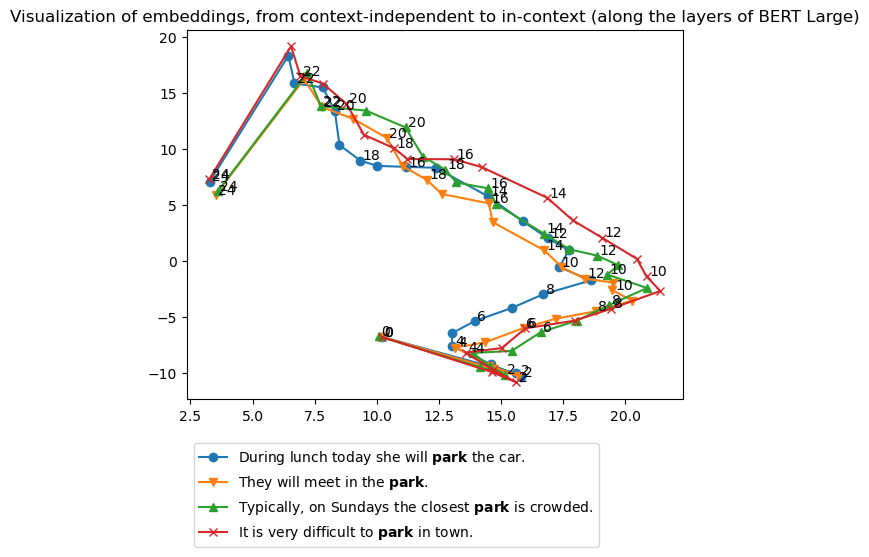

In [29]:
for (i,t) in enumerate(modified_texts):
    x = token_np_reduced[i*nr_layers:(i+1)*nr_layers,0]
    y = token_np_reduced[i*nr_layers:(i+1)*nr_layers,1]
    plt.plot(x, y, markers[i]+'-', label=t)
    for lay in range(nr_layers):
        if lay%2==0:
            plt.text(x[lay]+0.1, y[lay]+0.1, lay)
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1))
plt.title("Visualization of embeddings, from context-independent to in-context (along the layers of BERT Large)")
plt.show()

Let's look close at the start (layer 0, context-independent) and at the end (in-context, layer 24).

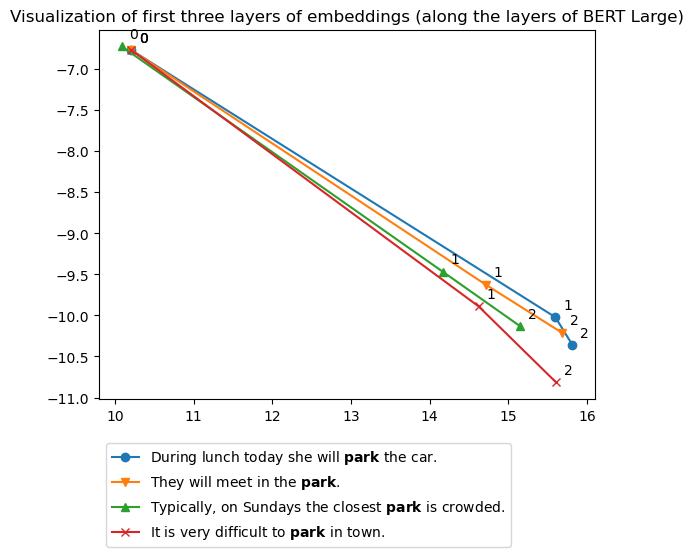

In [75]:
length=3
for (i,t) in enumerate(modified_texts):
    x = token_np_reduced[i*nr_layers:i*nr_layers+length,0]
    y = token_np_reduced[i*nr_layers:i*nr_layers+length,1]
    plt.plot(x, y, markers[i]+'-', label=t)
    for lay in range(length):
        plt.text(x[lay]+0.1, y[lay]+0.1, lay)
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1))
plt.title("Visualization of first three layers of embeddings (along the layers of BERT Large)")

plt.show()

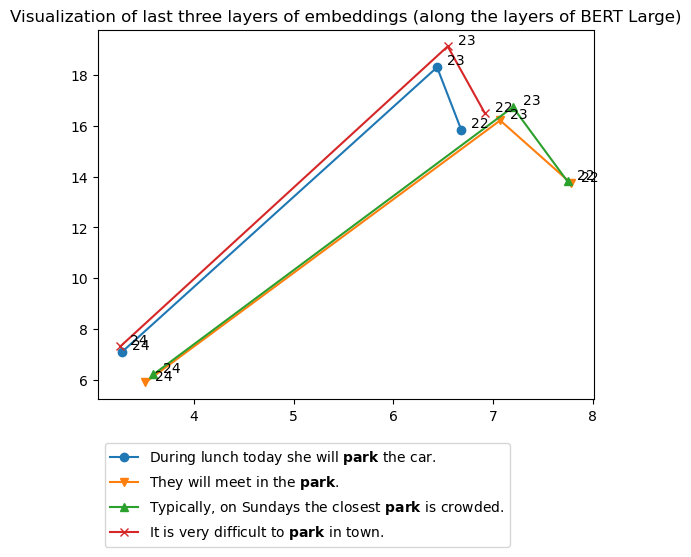

In [74]:
length=3
for (i,t) in enumerate(modified_texts):
    x = token_np_reduced[(i+1)*nr_layers-length:(i+1)*nr_layers,0]
    y = token_np_reduced[(i+1)*nr_layers-length:(i+1)*nr_layers,1]
    plt.plot(x, y, markers[i]+'-', label=t)
    for lay in range(length-1,-1,-1):
        plt.text(x[lay]+0.1, y[lay]+0.1, nr_layers-length+lay)
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1))
plt.title("Visualization of last three layers of embeddings (along the layers of BERT Large)")

plt.show()

We clearly observe that at the start of the encoding through transformers, all the embeddings for "park" are together. There are small differences, because the word encoding is combined with the position encoding (the position of the word in the sentence). After going 24 times through the transformers, we can see a clear split between the embeddings for "park", whether "park" is meant as the verb "to park a car", or meant as the place "park".

## Semantic Search using sentence embeddings

It is very interesting to observe how the transformers encode the semantic meaning of a word. But what about an entire sentence? We observe that the sentence embeddings of OpenAI are a very powerful tool to identify text passages that are relevant to answer a question. In such cases, a question is embedded, as well as passages. Then the passages whose embeddings are closest to the question's embedding are the one that can most likely help answering the question. While this seems surprising, it works well in practice. So let's dive deeper into this topic.

First you might have to install openai, and need the libraries. There is some redundancy with the above code, but this is to allow you to run it independently.

In [2]:
#!pip install openai

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import openai
openai.api_key = "YOU_API_KEY"

Let's define a function that will return the embeddings in form of a numpy array. and let's test it.

In [5]:
def embedding(input):
    emb = openai.Embedding.create(
      model="text-embedding-ada-002",
      input=input
    )
    return np.array(emb['data'][0]['embedding'])

In [6]:
e = embedding("Hi there!")
print("Dimension of a vector: ", e.shape)

Dimension of a vector:  (1536,)


Let's now write a couple of sentences. The first one is the question we want to answer. The other ones are passges that might be or might not be useful to answer the question.

In [7]:
texts = ["Who is Philipp?"
         ,"Philippe is a football player.",
         "Philipp is a guitarist.",
         "Philip is a basketball player."
         ,"Philipp likes music."
         ,"Philipp goes to the beach today."
         ,"Claude is a guitarist."
         ,"Chiara is a funny person."
         ,"Philipp is a person who cares about others. Chiara is also a person who cares about others. Olivia is a great person."
         ,"Philipp is a person who cares about others."
        ]

Let's do some data processing to get the right format, that will be useful to analyse the text and visualize it.

In [9]:
embed = []
for t in texts:
    embed.append(embedding(t))
nr_texts = len(texts)
vec_size = embed[0].shape[0]

In [10]:
# Get all vectors put into a single numpy array as preparation for the visualization
texts_embedded=np.zeros((nr_texts,vec_size))
for (i,t) in enumerate(texts):
    texts_embedded[i,:]=embed[i]

In order to visualize the distance between these vecetors we reduce the dimensionality of the vectors to 2 dimensions. This reduction is done with the Truncated SVC method (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html">link</a>). We also use a function to display the output.

These two functions are inspired by exercises from the course CS224N from Stanford.

In [15]:
def reduce_to_k_dim(M, k=2):
    """Params:
            M (numpy matrix of shape (number of vectors, size of vectors))
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (number of vectors, k) - k is the new (reduced) dimension of the vectors
    """    
    n_iters = 10
    M_reduced = None
    print("Running Truncated SVD.")
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)    

    print("Done.")
    return M_reduced

In [16]:
texts_embedded_reduced = reduce_to_k_dim(texts_embedded, k=2)

Running Truncated SVD.
Done.


In [17]:
def plot_embeddings(M_reduced, sentences):
    """ Plot in a scatterplot the embeddings of the sentences.
        Display the sentence next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of vectors, k))
            sentences (List of sentences)
    """

    for (i,sent) in enumerate(sentences):
        x, y = M_reduced[i,:]
        if i==0:
            marker='x'
            color='red'
        else:
            marker='*'
            color='blue'            
        plt.scatter(x, y, marker=marker, color=color)
        plt.text(x+0.0005, y+0.01, sent)
    plt.figure(figsize=(4,4))
    plt.show()

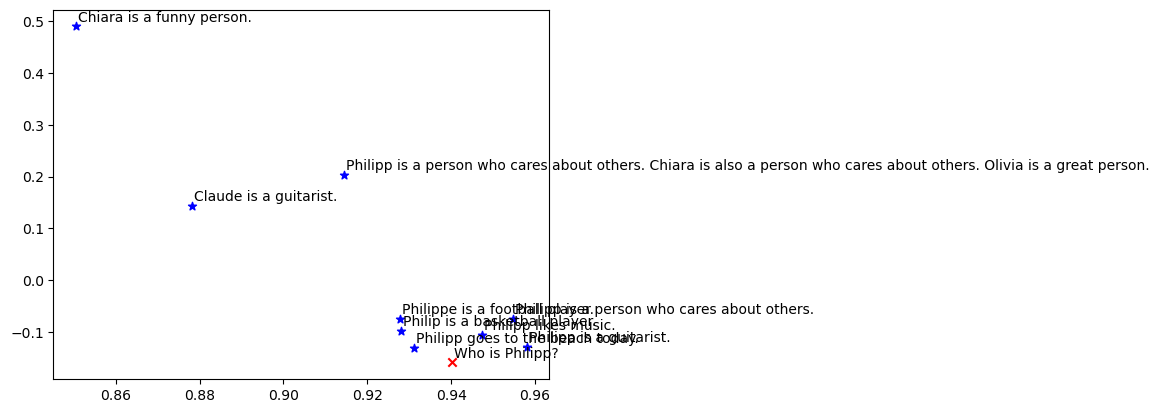

<Figure size 400x400 with 0 Axes>

In [18]:
plot_embeddings(texts_embedded_reduced, texts)

Let's look for another way to represent the distance between the question and the passages to answer the question. We calculate the cosine similarity between the question and all the answers and put them into a dataframe. The cosine similarity provide the notion of distance, how far are the vectors from each other.

In [22]:
sim = []
for (i,e) in enumerate(embed):
    sim.append({"Text": texts[i], "Similarity": np.dot(embed[0],e)})
df = pd.DataFrame(sim)

In [23]:
df.sort_values(by="Similarity", ascending=False)

,Text,Similarity
0,Who is Philipp?,1.000000
9,Philipp is a person who cares about others.,0.920248
2,Philipp is a guitarist.,0.913956
4,Philipp likes music.,0.889526
5,Philipp goes to the beach today.,0.877080
3,Philip is a basketball player.,0.867387
1,Philippe is a football player.,0.856666
8,Philipp is a person who cares about others. Ch...,0.848745
6,Claude is a guitarist.,0.753810
7,Chiara is a funny person.,0.738853


Both representations are very informative. Let's analyse the results.

To answer the question "Who is Philipp?", the first point is to identify the passages where the name of Philipp appears. We can see that this works well! The system was not tricked by us using various spelling of Philipp. It sticked to the right one!

One issue though is that passage 8 would be very relevant to answer the question. Unfortunately this information got dilulted with additional information, so that it is too far from the question to be identified as relevant by the cosine simlarity. This is very instructive as it tells us that we should not have too long passages when using this technique.

Finally we observe that the passages that define who is Philipp ("Philipp is a guitarist") are higher ranked than passages that mention him but do not define him ("Philipp goes to the beach today.").

The conclusion is:
- The approach is great at idenfitying passages mentioning Philipp
- The approach is also good at identifying which passages define who is Philipp vs what does Philipp
- Dilution of information due to longer passages is an issue

## Conclusion

In this article we have looked at both word embedding and text embedding. While we observe that text embedding is heavily used in practice (and works in general well), we notice some limitations of this approach, which we did not observe when using word embeddings.

Therefore, when working on a project where semantic search is needed, we recommend to analyse the requirements in details and check if the sentence embeddings satisfy the requirements, before indexing entire corpus with this technique, especially because indexing "en masse" is associated with costs.